In [61]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from sklearn.metrics import balanced_accuracy_score as BACC
from sklearn.model_selection import train_test_split
import eval_scores as eval
import cv2 as cv
import random

In [62]:
def augment_data(xtrain, ytrain):
    print(xtrain.shape, ytrain.shape)
    #(6470, 50, 50) (6470,)
    #(50, 50) ()
    xtrain_len = len(xtrain)
    
    aug_xtrain = np.zeros((xtrain_len*2, 50, 50))
    aug_ytrain = np.zeros((xtrain_len*2))
    
    aug_xtrain[0:xtrain_len, :, :] = xtrain
    aug_ytrain[0:xtrain_len] = ytrain
    
    for idx in range(xtrain_len):
        image = xtrain[idx,:,:]
        label = ytrain[idx]
                
        angle = int(random.uniform(-90, 90))
        h, w = image.shape[0], image.shape[1]
        M = cv.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
        rotated = cv.warpAffine(image, M, (w, h))
        
        flipped = cv.flip(rotated, 1)


        aug_xtrain[xtrain_len+idx] = flipped
        aug_ytrain[xtrain_len+idx] = label
        
        
    return aug_xtrain, aug_ytrain

In [63]:
xtrain = np.load("Xtrain_Classification_Part1.npy")
ytrain = np.load("Ytrain_Classification_Part1.npy")
xtrain_len = len(xtrain)
ytrain_len = len(ytrain)

#Reshape Images
xtrain = xtrain.reshape((xtrain_len,50,50))
mean = xtrain.mean(axis=(0, 1, 2)) 
std = xtrain.std(axis=(0, 1, 2))

xtrain = (xtrain - mean)/std  

xtrain, ytrain = augment_data(xtrain, ytrain)

(6470, 50, 50) (6470,)


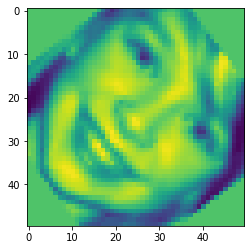

In [64]:
plt.imshow(xtrain[6479,:,:])
plt.show()

In [65]:
class ImageDataset(Dataset):
    def __init__(self):
        xtrain = np.load("Xtrain_Classification_Part1.npy")
        ytrain = np.load("Ytrain_Classification_Part1.npy")
        xtest = np.load("Xtest_Classification_Part1.npy")


        xtrain_len = len(xtrain)
        ytrain_len = len(ytrain)
        xtest_len = len(xtest)

        #Reshape Images
        xtrain = xtrain.reshape((xtrain_len,50,50))
        mean = xtrain.mean(axis=(0, 1, 2)) 
        std = xtrain.std(axis=(0, 1, 2))

        xtrain = (xtrain - mean)/std  
        
        xtrain, ytrain = augment_data(xtrain, ytrain)
        
        new_xtrain_len = len(xtrain)
        new_ytrain_len = len(ytrain)
        
        self.xtrain = xtrain.reshape((new_xtrain_len,1,50,50))
        self.xtest = xtest.reshape((xtest_len,1,50,50))

        self.ytrain = ytrain.reshape(new_ytrain_len)

    def __len__(self):
        return len(self.xtrain)

    def __getitem__(self, idx):
        #mage = self.xtrain[idx,:,:,:].reshape((50,50))
        #image = cv.resize(image, (25,25))
        #image = image.reshape(1,25,25)
        
        image = self.xtrain[idx, :, :, :]
        label = self.ytrain[idx]
        

        return image, label
    

In [66]:
class ClassifyNet(nn.Module):

    def __init__(self):
        super(ClassifyNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10,
                              kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20,
                              kernel_size=5, stride=1)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(in_features=1620, out_features=800)
        self.fc2 = nn.Linear(in_features=1620, out_features=1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        
        #print(x.shape)
        
        x = x.view(x.shape[0], -1)
        
        x = self.dropout(x)
        
        #print(x.shape)
        
        #x = self.fc1(x)
        #x = F.relu(x)
        
        #x = self.dropout(x)
        
        x = self.fc2(x)
        x = torch.sigmoid(x)
                
        return x

In [67]:
config = {
    'batch_size' : 64,
    'lr' : 0.001,
    'momentum' : 0.9
}

In [68]:
def train_model(model):
    
    num_epochs = 400
    best_score = 1.0
    
    for epoch in range(num_epochs):
        
        model.train()
        running_loss = 0.0
        
        criterion = nn.BCELoss()
        
        for idx, data in enumerate(train_loader):
            image, label = data[0].float().to(device), data[1].float()
            
            
            optimizer.zero_grad()
            
            classify_output = model(image)
            
            
            y_true = torch.reshape(label.cpu(), (-1,))
            y_pred = torch.reshape(classify_output.cpu(), (-1,))
            
            loss = criterion(y_pred, y_true)

            #print(loss)

            loss.backward()
            optimizer.step()
            
            # print for mini batches
            running_loss += loss.item()
            if idx % 50 == 49:  # every 50 mini batches
                print('[Epoch %d, %5d Mini Batches] loss: %.3f' %
                      (epoch + 1, idx + 1, running_loss/50))
                running_loss = 0.0
               
        model.eval()
        test_score = 0.0
        
         
        with torch.no_grad():
            for idx, data in enumerate(test_loader):
                image, label = data[0].float().to(device), data[1].float()

                classify_output = model(image)

                y_true = torch.reshape(label.cpu(), (-1,))
                y_pred = torch.reshape(classify_output.cpu(), (-1,))

                test_loss = criterion(y_pred, y_true)

                test_score += test_loss

            test_score /= len(test_loader)

            print(test_score)

            if test_score < best_score:
                torch.save(model, "ClassifyNet.pth")
                best_score = test_score
        

In [69]:
data_set = ImageDataset()

train_set, test_set = train_test_split(data_set, test_size=0.2, random_state=1, shuffle=True)

train_loader = DataLoader(train_set, batch_size=config['batch_size'], shuffle=True)
test_loader = DataLoader(test_set, batch_size=config['batch_size'], shuffle=True)

(6470, 50, 50) (6470,)


In [70]:
torch.cuda.empty_cache()

In [71]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device= torch.device('cpu')
model = ClassifyNet().to(device)

optimizer = optim.SGD(model.parameters(), lr=config['lr'], momentum=config['momentum'])

In [ ]:
train_model(model)

[Epoch 1,    50 Mini Batches] loss: 0.681
[Epoch 1,   100 Mini Batches] loss: 0.660
[Epoch 1,   150 Mini Batches] loss: 0.638
tensor(0.6084)
[Epoch 2,    50 Mini Batches] loss: 0.611
[Epoch 2,   100 Mini Batches] loss: 0.596
[Epoch 2,   150 Mini Batches] loss: 0.591
tensor(0.5662)
[Epoch 3,    50 Mini Batches] loss: 0.576
[Epoch 3,   100 Mini Batches] loss: 0.582
[Epoch 3,   150 Mini Batches] loss: 0.574
tensor(0.5470)
[Epoch 4,    50 Mini Batches] loss: 0.568
[Epoch 4,   100 Mini Batches] loss: 0.556
[Epoch 4,   150 Mini Batches] loss: 0.564
tensor(0.5525)
[Epoch 5,    50 Mini Batches] loss: 0.563
[Epoch 5,   100 Mini Batches] loss: 0.550
[Epoch 5,   150 Mini Batches] loss: 0.548
tensor(0.5199)
[Epoch 6,    50 Mini Batches] loss: 0.546
[Epoch 6,   100 Mini Batches] loss: 0.532
[Epoch 6,   150 Mini Batches] loss: 0.536
tensor(0.5117)
[Epoch 7,    50 Mini Batches] loss: 0.521
[Epoch 7,   100 Mini Batches] loss: 0.530
[Epoch 7,   150 Mini Batches] loss: 0.539
tensor(0.5013)
[Epoch 8,    

[Epoch 58,   100 Mini Batches] loss: 0.347
[Epoch 58,   150 Mini Batches] loss: 0.352
tensor(0.3603)
[Epoch 59,    50 Mini Batches] loss: 0.344
[Epoch 59,   100 Mini Batches] loss: 0.356
[Epoch 59,   150 Mini Batches] loss: 0.353
tensor(0.3617)
[Epoch 60,    50 Mini Batches] loss: 0.342
[Epoch 60,   100 Mini Batches] loss: 0.356
[Epoch 60,   150 Mini Batches] loss: 0.356
tensor(0.3641)
[Epoch 61,    50 Mini Batches] loss: 0.347
[Epoch 61,   100 Mini Batches] loss: 0.346
[Epoch 61,   150 Mini Batches] loss: 0.347
tensor(0.3584)
[Epoch 62,    50 Mini Batches] loss: 0.348
[Epoch 62,   100 Mini Batches] loss: 0.351
[Epoch 62,   150 Mini Batches] loss: 0.341
tensor(0.3694)
[Epoch 63,    50 Mini Batches] loss: 0.366
[Epoch 63,   100 Mini Batches] loss: 0.341
[Epoch 63,   150 Mini Batches] loss: 0.342
tensor(0.3594)
[Epoch 64,    50 Mini Batches] loss: 0.342
[Epoch 64,   100 Mini Batches] loss: 0.344
[Epoch 64,   150 Mini Batches] loss: 0.337
tensor(0.3633)
[Epoch 65,    50 Mini Batches] loss

tensor(0.3532)
[Epoch 115,    50 Mini Batches] loss: 0.279
[Epoch 115,   100 Mini Batches] loss: 0.275
[Epoch 115,   150 Mini Batches] loss: 0.270
tensor(0.3502)
[Epoch 116,    50 Mini Batches] loss: 0.287
[Epoch 116,   100 Mini Batches] loss: 0.269
[Epoch 116,   150 Mini Batches] loss: 0.280
tensor(0.3539)
[Epoch 117,    50 Mini Batches] loss: 0.270
[Epoch 117,   100 Mini Batches] loss: 0.272
[Epoch 117,   150 Mini Batches] loss: 0.295
tensor(0.3496)
[Epoch 118,    50 Mini Batches] loss: 0.273
[Epoch 118,   100 Mini Batches] loss: 0.281
[Epoch 118,   150 Mini Batches] loss: 0.282
tensor(0.3506)
[Epoch 119,    50 Mini Batches] loss: 0.285
[Epoch 119,   100 Mini Batches] loss: 0.265
[Epoch 119,   150 Mini Batches] loss: 0.270
tensor(0.3484)
[Epoch 120,    50 Mini Batches] loss: 0.280
[Epoch 120,   100 Mini Batches] loss: 0.269
[Epoch 120,   150 Mini Batches] loss: 0.284
tensor(0.3605)
[Epoch 121,    50 Mini Batches] loss: 0.275
[Epoch 121,   100 Mini Batches] loss: 0.280
[Epoch 121,   1

tensor(0.3705)
[Epoch 171,    50 Mini Batches] loss: 0.239
[Epoch 171,   100 Mini Batches] loss: 0.235
[Epoch 171,   150 Mini Batches] loss: 0.237
tensor(0.3672)
[Epoch 172,    50 Mini Batches] loss: 0.238
[Epoch 172,   100 Mini Batches] loss: 0.216
[Epoch 172,   150 Mini Batches] loss: 0.240
tensor(0.3669)
[Epoch 173,    50 Mini Batches] loss: 0.230
[Epoch 173,   100 Mini Batches] loss: 0.223
[Epoch 173,   150 Mini Batches] loss: 0.242
tensor(0.3690)
[Epoch 174,    50 Mini Batches] loss: 0.232
[Epoch 174,   100 Mini Batches] loss: 0.245
[Epoch 174,   150 Mini Batches] loss: 0.229
tensor(0.3610)
[Epoch 175,    50 Mini Batches] loss: 0.233
[Epoch 175,   100 Mini Batches] loss: 0.231
[Epoch 175,   150 Mini Batches] loss: 0.222
tensor(0.3665)
[Epoch 176,    50 Mini Batches] loss: 0.223
[Epoch 176,   100 Mini Batches] loss: 0.231
[Epoch 176,   150 Mini Batches] loss: 0.228
tensor(0.3721)
[Epoch 177,    50 Mini Batches] loss: 0.227
[Epoch 177,   100 Mini Batches] loss: 0.239
[Epoch 177,   1

tensor(0.3848)
[Epoch 227,    50 Mini Batches] loss: 0.204
[Epoch 227,   100 Mini Batches] loss: 0.206
[Epoch 227,   150 Mini Batches] loss: 0.204
tensor(0.3861)
[Epoch 228,    50 Mini Batches] loss: 0.202
[Epoch 228,   100 Mini Batches] loss: 0.213
[Epoch 228,   150 Mini Batches] loss: 0.201
tensor(0.3901)
[Epoch 229,    50 Mini Batches] loss: 0.198
[Epoch 229,   100 Mini Batches] loss: 0.195
[Epoch 229,   150 Mini Batches] loss: 0.206
tensor(0.3899)
[Epoch 230,    50 Mini Batches] loss: 0.192
[Epoch 230,   100 Mini Batches] loss: 0.205
[Epoch 230,   150 Mini Batches] loss: 0.199
tensor(0.3854)
[Epoch 231,    50 Mini Batches] loss: 0.193
[Epoch 231,   100 Mini Batches] loss: 0.198


In [ ]:
# Test model against training data

model = torch.load("ClassifyNet.pth")

test_score = 0.0

with torch.no_grad():
    for idx, data in enumerate(test_loader):
        image, label = data[0].float().to(device), data[1].float()

        classify_output = model(image)

        y_true = torch.reshape(label.cpu(), (-1,)) > 0.5
        y_pred = torch.reshape(classify_output.cpu(), (-1,)) > 0.5
        
        test_loss = BACC(y_pred.numpy(), y_true.numpy())

        test_score += test_loss

test_score /= len(test_loader)

print(test_score)